In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"]= "1"

import jax 
import jax.numpy as jnp
import optax
import time 
import pickle
from tqdm import trange

from utils.spinn import SPINN3d, generate_train_data, apply_model_spinn, update_model
from utils.data_load import load_nc
from utils.metric import evaluate
from utils.plotting import plot_overview, plot_sample
from utils.validation import valid

In [2]:
base_path = '/mnt/userdata/jeon_mg/spinn/spinn/'
os.makedirs(base_path, exist_ok=True)
save_path = os.path.join(base_path, 'params.pickle')

features = 256
n_layers = 8 
r = 256
out_dim = 3 
lr = 1e-5

nc = 32

height = 257
iterations = 10000
log_iter = 10
random_iter = 100

b_norm = 2500

In [3]:
key = jax.random.PRNGKey(0)

# make & init model forward function
key, subkey = jax.random.split(key, 2)

feat_sizes = tuple([features for _ in range(n_layers)]) 

model = SPINN3d(feat_sizes, r, out_dim)

params = model.init(
                key,
                jnp.ones((nc, 1)),
                jnp.ones((nc, 1)),
                jnp.ones((nc, 1))
            )

apply_fn, params = jax.jit(model.apply), params

# count total params
total_params = sum(x.size for x in jax.tree_util.tree_leaves(params))

# optimizer
optim = optax.adam(learning_rate=lr)
state = optim.init(params)

2023-11-11 01:22:12.609324: W external/xla/xla/service/gpu/nvptx_compiler.cc:673] The NVIDIA driver's CUDA version is 11.4 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [4]:
b_true = load_nc('/mnt/obsdata/isee_nlfff_v1.2/11158/11158_20110213_120000.nc')

b_bottom = b_true[:, :, 0, :]
b_true.shape, b_bottom.shape

((513, 257, 257, 3), (513, 257, 3))

In [5]:
nx, ny, _ = b_bottom.shape
nz = height

In [6]:
b_bottom_normalized = b_bottom / b_norm

In [7]:
# dataset
key, subkey = jax.random.split(key, 2)
xc, yc, zc, xb, yb, zb = generate_train_data(nc, nx, ny, nz, subkey)


# start training
for e in trange(1, iterations + 1):
    if e == 2:
        # exclude compiling time
        start = time.time()

    if e % 100 == 0:
        key, subkey = jax.random.split(key, 2)
        xc, yc, zc, xb, yb, zb = generate_train_data(nc, nx, ny, nz, subkey)

    loss, gradient = apply_model_spinn(apply_fn, params, xc, yc, zc, xb, yb, zb, b_bottom_normalized)
    params, state = update_model(optim, gradient, params, state)

    # log
    if e % log_iter == 0:
        print(f'Iteration: {e}/{iterations} --> total loss: {loss:.8f}')

# training done
runtime = time.time() - start
print(f'Runtime --> total: {runtime:.2f}sec ({(runtime/(iterations-1)*1000):.2f}ms/iter.)')
with open(save_path, "wb") as f:
    pickle.dump(params, f)

Iteration: 6490/10000 --> total loss: 0.01296033
Iteration: 6500/10000 --> total loss: 0.01298894
Iteration: 6510/10000 --> total loss: 0.01295797


 65%|██████▌   | 6534/10000 [01:13<00:25, 134.92it/s]

Iteration: 6520/10000 --> total loss: 0.01294438
Iteration: 6530/10000 --> total loss: 0.01293794
Iteration: 6540/10000 --> total loss: 0.01293328


 66%|██████▌   | 6563/10000 [01:14<00:26, 132.13it/s]

Iteration: 6550/10000 --> total loss: 0.01293012
Iteration: 6560/10000 --> total loss: 0.01292760
Iteration: 6570/10000 --> total loss: 0.01292544


 66%|██████▌   | 6605/10000 [01:14<00:25, 133.51it/s]

Iteration: 6580/10000 --> total loss: 0.01292348
Iteration: 6590/10000 --> total loss: 0.01292168
Iteration: 6600/10000 --> total loss: 0.01319341


 66%|██████▋   | 6633/10000 [01:14<00:25, 131.90it/s]

Iteration: 6610/10000 --> total loss: 0.01311346
Iteration: 6620/10000 --> total loss: 0.01309100
Iteration: 6630/10000 --> total loss: 0.01307702


 67%|██████▋   | 6661/10000 [01:14<00:25, 132.51it/s]

Iteration: 6640/10000 --> total loss: 0.01306721
Iteration: 6650/10000 --> total loss: 0.01306097
Iteration: 6660/10000 --> total loss: 0.01305667


 67%|██████▋   | 6689/10000 [01:15<00:24, 133.88it/s]

Iteration: 6670/10000 --> total loss: 0.01305341
Iteration: 6680/10000 --> total loss: 0.01305067
Iteration: 6690/10000 --> total loss: 0.01304824


 67%|██████▋   | 6717/10000 [01:15<00:24, 131.85it/s]

Iteration: 6700/10000 --> total loss: 0.01299164
Iteration: 6710/10000 --> total loss: 0.01293986
Iteration: 6720/10000 --> total loss: 0.01292084


 67%|██████▋   | 6745/10000 [01:15<00:24, 130.67it/s]

Iteration: 6730/10000 --> total loss: 0.01290881
Iteration: 6740/10000 --> total loss: 0.01290048
Iteration: 6750/10000 --> total loss: 0.01289421


 68%|██████▊   | 6787/10000 [01:15<00:24, 133.73it/s]

Iteration: 6760/10000 --> total loss: 0.01288909
Iteration: 6770/10000 --> total loss: 0.01288457
Iteration: 6780/10000 --> total loss: 0.01288057


 68%|██████▊   | 6815/10000 [01:16<00:24, 131.50it/s]

Iteration: 6790/10000 --> total loss: 0.01287694
Iteration: 6800/10000 --> total loss: 0.01296361
Iteration: 6810/10000 --> total loss: 0.01292368


 68%|██████▊   | 6843/10000 [01:16<00:24, 129.78it/s]

Iteration: 6820/10000 --> total loss: 0.01290641
Iteration: 6830/10000 --> total loss: 0.01291695
Iteration: 6840/10000 --> total loss: 0.01292997


 69%|██████▊   | 6871/10000 [01:16<00:23, 131.89it/s]

Iteration: 6850/10000 --> total loss: 0.01288501
Iteration: 6860/10000 --> total loss: 0.01287816
Iteration: 6870/10000 --> total loss: 0.01287056


 69%|██████▉   | 6899/10000 [01:16<00:23, 132.05it/s]

Iteration: 6880/10000 --> total loss: 0.01286586
Iteration: 6890/10000 --> total loss: 0.01285964
Iteration: 6900/10000 --> total loss: 0.01345205


 69%|██████▉   | 6927/10000 [01:16<00:23, 132.11it/s]

Iteration: 6910/10000 --> total loss: 0.01314313
Iteration: 6920/10000 --> total loss: 0.01307408
Iteration: 6930/10000 --> total loss: 0.01303940


 70%|██████▉   | 6955/10000 [01:17<00:22, 133.17it/s]

Iteration: 6940/10000 --> total loss: 0.01302365
Iteration: 6950/10000 --> total loss: 0.01301466
Iteration: 6960/10000 --> total loss: 0.01300936


 70%|██████▉   | 6997/10000 [01:17<00:22, 133.31it/s]

Iteration: 6970/10000 --> total loss: 0.01300515
Iteration: 6980/10000 --> total loss: 0.01300179
Iteration: 6990/10000 --> total loss: 0.01299885


 70%|███████   | 7025/10000 [01:17<00:22, 132.90it/s]

Iteration: 7000/10000 --> total loss: 0.01305757
Iteration: 7010/10000 --> total loss: 0.01298366
Iteration: 7020/10000 --> total loss: 0.01296319


 71%|███████   | 7053/10000 [01:17<00:21, 134.73it/s]

Iteration: 7030/10000 --> total loss: 0.01294959
Iteration: 7040/10000 --> total loss: 0.01294201
Iteration: 7050/10000 --> total loss: 0.01293673


 71%|███████   | 7081/10000 [01:18<00:21, 135.87it/s]

Iteration: 7060/10000 --> total loss: 0.01293314
Iteration: 7070/10000 --> total loss: 0.01293025
Iteration: 7080/10000 --> total loss: 0.01292783


 71%|███████   | 7110/10000 [01:18<00:21, 134.49it/s]

Iteration: 7090/10000 --> total loss: 0.01292570
Iteration: 7100/10000 --> total loss: 0.01322920
Iteration: 7110/10000 --> total loss: 0.01312782


 71%|███████▏  | 7138/10000 [01:18<00:21, 135.52it/s]

Iteration: 7120/10000 --> total loss: 0.01309745
Iteration: 7130/10000 --> total loss: 0.01308147
Iteration: 7140/10000 --> total loss: 0.01307210


 72%|███████▏  | 7166/10000 [01:18<00:21, 134.49it/s]

Iteration: 7150/10000 --> total loss: 0.01306644
Iteration: 7160/10000 --> total loss: 0.01306226
Iteration: 7170/10000 --> total loss: 0.01305901


 72%|███████▏  | 7194/10000 [01:18<00:20, 136.27it/s]

Iteration: 7180/10000 --> total loss: 0.01305631
Iteration: 7190/10000 --> total loss: 0.01305393
Iteration: 7200/10000 --> total loss: 0.01287360


 72%|███████▏  | 7237/10000 [01:19<00:20, 136.71it/s]

Iteration: 7210/10000 --> total loss: 0.01278742
Iteration: 7220/10000 --> total loss: 0.01275900
Iteration: 7230/10000 --> total loss: 0.01274022


 73%|███████▎  | 7266/10000 [01:19<00:19, 136.91it/s]

Iteration: 7240/10000 --> total loss: 0.01272365
Iteration: 7250/10000 --> total loss: 0.01271037
Iteration: 7260/10000 --> total loss: 0.01269899


 73%|███████▎  | 7294/10000 [01:19<00:20, 134.35it/s]

Iteration: 7270/10000 --> total loss: 0.01268912
Iteration: 7280/10000 --> total loss: 0.01268030
Iteration: 7290/10000 --> total loss: 0.01267229


 73%|███████▎  | 7322/10000 [01:19<00:19, 135.74it/s]

Iteration: 7300/10000 --> total loss: 0.01292367
Iteration: 7310/10000 --> total loss: 0.01285097
Iteration: 7320/10000 --> total loss: 0.01282190


 74%|███████▎  | 7350/10000 [01:20<00:19, 136.04it/s]

Iteration: 7330/10000 --> total loss: 0.01280503
Iteration: 7340/10000 --> total loss: 0.01279549
Iteration: 7350/10000 --> total loss: 0.01278926


 74%|███████▍  | 7378/10000 [01:20<00:19, 134.63it/s]

Iteration: 7360/10000 --> total loss: 0.01278450
Iteration: 7370/10000 --> total loss: 0.01279622
Iteration: 7380/10000 --> total loss: 0.01278763


 74%|███████▍  | 7406/10000 [01:20<00:19, 135.61it/s]

Iteration: 7390/10000 --> total loss: 0.01277875
Iteration: 7400/10000 --> total loss: 0.01312980
Iteration: 7410/10000 --> total loss: 0.01312610


 74%|███████▍  | 7434/10000 [01:20<00:19, 134.91it/s]

Iteration: 7420/10000 --> total loss: 0.01304747
Iteration: 7430/10000 --> total loss: 0.01298321
Iteration: 7440/10000 --> total loss: 0.01296991


 75%|███████▍  | 7476/10000 [01:21<00:18, 134.98it/s]

Iteration: 7450/10000 --> total loss: 0.01296041
Iteration: 7460/10000 --> total loss: 0.01295542
Iteration: 7470/10000 --> total loss: 0.01295153


 75%|███████▌  | 7504/10000 [01:21<00:18, 134.03it/s]

Iteration: 7480/10000 --> total loss: 0.01294872
Iteration: 7490/10000 --> total loss: 0.01294637
Iteration: 7500/10000 --> total loss: 0.01277597


 75%|███████▌  | 7532/10000 [01:21<00:18, 132.37it/s]

Iteration: 7510/10000 --> total loss: 0.01271670
Iteration: 7520/10000 --> total loss: 0.01269482
Iteration: 7530/10000 --> total loss: 0.01267714


 76%|███████▌  | 7560/10000 [01:21<00:18, 131.36it/s]

Iteration: 7540/10000 --> total loss: 0.01266207
Iteration: 7550/10000 --> total loss: 0.01264910
Iteration: 7560/10000 --> total loss: 0.01263754


 76%|███████▌  | 7588/10000 [01:21<00:18, 128.33it/s]

Iteration: 7570/10000 --> total loss: 0.01262709
Iteration: 7580/10000 --> total loss: 0.01261753
Iteration: 7590/10000 --> total loss: 0.01260872


 76%|███████▌  | 7616/10000 [01:22<00:18, 132.24it/s]

Iteration: 7600/10000 --> total loss: 0.01339000
Iteration: 7610/10000 --> total loss: 0.01362323
Iteration: 7620/10000 --> total loss: 0.01305254


 76%|███████▋  | 7644/10000 [01:22<00:18, 128.06it/s]

Iteration: 7630/10000 --> total loss: 0.01306451
Iteration: 7640/10000 --> total loss: 0.01296654
Iteration: 7650/10000 --> total loss: 0.01292374


 77%|███████▋  | 7674/10000 [01:22<00:17, 136.41it/s]

Iteration: 7660/10000 --> total loss: 0.01291919
Iteration: 7670/10000 --> total loss: 0.01291014
Iteration: 7680/10000 --> total loss: 0.01290537


 77%|███████▋  | 7719/10000 [01:22<00:16, 141.63it/s]

Iteration: 7690/10000 --> total loss: 0.01290096
Iteration: 7700/10000 --> total loss: 0.01290047
Iteration: 7710/10000 --> total loss: 0.01283042


 77%|███████▋  | 7749/10000 [01:23<00:15, 143.14it/s]

Iteration: 7720/10000 --> total loss: 0.01280953
Iteration: 7730/10000 --> total loss: 0.01279624
Iteration: 7740/10000 --> total loss: 0.01278743


 78%|███████▊  | 7779/10000 [01:23<00:15, 145.06it/s]

Iteration: 7750/10000 --> total loss: 0.01278063
Iteration: 7760/10000 --> total loss: 0.01277521
Iteration: 7770/10000 --> total loss: 0.01277039


 78%|███████▊  | 7809/10000 [01:23<00:15, 144.57it/s]

Iteration: 7780/10000 --> total loss: 0.01276604
Iteration: 7790/10000 --> total loss: 0.01276203
Iteration: 7800/10000 --> total loss: 0.01301576


 78%|███████▊  | 7824/10000 [01:23<00:15, 143.97it/s]

Iteration: 7810/10000 --> total loss: 0.01290533
Iteration: 7820/10000 --> total loss: 0.01288308
Iteration: 7830/10000 --> total loss: 0.01286648


 79%|███████▊  | 7869/10000 [01:23<00:14, 144.36it/s]

Iteration: 7840/10000 --> total loss: 0.01285878
Iteration: 7850/10000 --> total loss: 0.01285352
Iteration: 7860/10000 --> total loss: 0.01284971


 79%|███████▉  | 7884/10000 [01:23<00:14, 143.73it/s]

Iteration: 7870/10000 --> total loss: 0.01284647
Iteration: 7880/10000 --> total loss: 0.01284365
Iteration: 7890/10000 --> total loss: 0.01284109


 79%|███████▉  | 7915/10000 [01:24<00:14, 144.32it/s]

Iteration: 7900/10000 --> total loss: 0.01318326
Iteration: 7910/10000 --> total loss: 0.01307599
Iteration: 7920/10000 --> total loss: 0.01303864


 79%|███████▉  | 7945/10000 [01:24<00:14, 144.46it/s]

Iteration: 7930/10000 --> total loss: 0.01302068
Iteration: 7940/10000 --> total loss: 0.01300971
Iteration: 7950/10000 --> total loss: 0.01300244


 80%|███████▉  | 7975/10000 [01:24<00:14, 142.62it/s]

Iteration: 7960/10000 --> total loss: 0.01299729
Iteration: 7970/10000 --> total loss: 0.01299316
Iteration: 7980/10000 --> total loss: 0.01298977


 80%|████████  | 8005/10000 [01:24<00:13, 142.97it/s]

Iteration: 7990/10000 --> total loss: 0.01298688
Iteration: 8000/10000 --> total loss: 0.01299926
Iteration: 8010/10000 --> total loss: 0.01289738


 80%|████████  | 8035/10000 [01:25<00:13, 143.62it/s]

Iteration: 8020/10000 --> total loss: 0.01286905
Iteration: 8030/10000 --> total loss: 0.01285012
Iteration: 8040/10000 --> total loss: 0.01283879


 81%|████████  | 8065/10000 [01:25<00:13, 144.63it/s]

Iteration: 8050/10000 --> total loss: 0.01283050
Iteration: 8060/10000 --> total loss: 0.01282420
Iteration: 8070/10000 --> total loss: 0.01281885


 81%|████████  | 8095/10000 [01:25<00:13, 144.15it/s]

Iteration: 8080/10000 --> total loss: 0.01281419
Iteration: 8090/10000 --> total loss: 0.01280998
Iteration: 8100/10000 --> total loss: 0.01299721


 81%|████████▏ | 8125/10000 [01:25<00:13, 140.88it/s]

Iteration: 8110/10000 --> total loss: 0.01287856
Iteration: 8120/10000 --> total loss: 0.01282607
Iteration: 8130/10000 --> total loss: 0.01279771


 82%|████████▏ | 8155/10000 [01:25<00:12, 142.84it/s]

Iteration: 8140/10000 --> total loss: 0.01278341
Iteration: 8150/10000 --> total loss: 0.01277411
Iteration: 8160/10000 --> total loss: 0.01276722


 82%|████████▏ | 8185/10000 [01:26<00:12, 141.66it/s]

Iteration: 8170/10000 --> total loss: 0.01276151
Iteration: 8180/10000 --> total loss: 0.01275651
Iteration: 8190/10000 --> total loss: 0.01275199


 82%|████████▏ | 8215/10000 [01:26<00:12, 141.17it/s]

Iteration: 8200/10000 --> total loss: 0.01308540
Iteration: 8210/10000 --> total loss: 0.01301568
Iteration: 8220/10000 --> total loss: 0.01293326


 82%|████████▏ | 8245/10000 [01:26<00:12, 141.04it/s]

Iteration: 8230/10000 --> total loss: 0.01291526
Iteration: 8240/10000 --> total loss: 0.01290061
Iteration: 8250/10000 --> total loss: 0.01289512


 83%|████████▎ | 8275/10000 [01:26<00:12, 140.71it/s]

Iteration: 8260/10000 --> total loss: 0.01289148
Iteration: 8270/10000 --> total loss: 0.01288886
Iteration: 8280/10000 --> total loss: 0.01288833


 83%|████████▎ | 8305/10000 [01:26<00:11, 142.98it/s]

Iteration: 8290/10000 --> total loss: 0.01288645
Iteration: 8300/10000 --> total loss: 0.01269712
Iteration: 8310/10000 --> total loss: 0.01258722


 83%|████████▎ | 8335/10000 [01:27<00:11, 143.73it/s]

Iteration: 8320/10000 --> total loss: 0.01254390
Iteration: 8330/10000 --> total loss: 0.01251080
Iteration: 8340/10000 --> total loss: 0.01248486


 84%|████████▎ | 8365/10000 [01:27<00:11, 142.51it/s]

Iteration: 8350/10000 --> total loss: 0.01246284
Iteration: 8360/10000 --> total loss: 0.01244346
Iteration: 8370/10000 --> total loss: 0.01242590


 84%|████████▍ | 8395/10000 [01:27<00:11, 143.14it/s]

Iteration: 8380/10000 --> total loss: 0.01240976
Iteration: 8390/10000 --> total loss: 0.01239475
Iteration: 8400/10000 --> total loss: 0.01349084


 84%|████████▍ | 8425/10000 [01:27<00:11, 142.32it/s]

Iteration: 8410/10000 --> total loss: 0.01327386
Iteration: 8420/10000 --> total loss: 0.01299197
Iteration: 8430/10000 --> total loss: 0.01286577


 85%|████████▍ | 8456/10000 [01:27<00:10, 144.74it/s]

Iteration: 8440/10000 --> total loss: 0.01284568
Iteration: 8450/10000 --> total loss: 0.01281617
Iteration: 8460/10000 --> total loss: 0.01280454


 85%|████████▍ | 8486/10000 [01:28<00:10, 143.07it/s]

Iteration: 8470/10000 --> total loss: 0.01279534
Iteration: 8480/10000 --> total loss: 0.01278793
Iteration: 8490/10000 --> total loss: 0.01278363


 85%|████████▌ | 8516/10000 [01:28<00:10, 141.29it/s]

Iteration: 8500/10000 --> total loss: 0.01268303
Iteration: 8510/10000 --> total loss: 0.01258644
Iteration: 8520/10000 --> total loss: 0.01254742


 85%|████████▌ | 8546/10000 [01:28<00:10, 144.04it/s]

Iteration: 8530/10000 --> total loss: 0.01252347
Iteration: 8540/10000 --> total loss: 0.01250723
Iteration: 8550/10000 --> total loss: 0.01249467


 86%|████████▌ | 8576/10000 [01:28<00:10, 142.02it/s]

Iteration: 8560/10000 --> total loss: 0.01248461
Iteration: 8570/10000 --> total loss: 0.01247623
Iteration: 8580/10000 --> total loss: 0.01246893


 86%|████████▌ | 8606/10000 [01:29<00:09, 144.66it/s]

Iteration: 8590/10000 --> total loss: 0.01246238
Iteration: 8600/10000 --> total loss: 0.01272276
Iteration: 8610/10000 --> total loss: 0.01263433


 86%|████████▋ | 8636/10000 [01:29<00:09, 145.39it/s]

Iteration: 8620/10000 --> total loss: 0.01258416
Iteration: 8630/10000 --> total loss: 0.01257038
Iteration: 8640/10000 --> total loss: 0.01255126


 87%|████████▋ | 8667/10000 [01:29<00:09, 145.95it/s]

Iteration: 8650/10000 --> total loss: 0.01254277
Iteration: 8660/10000 --> total loss: 0.01253496
Iteration: 8670/10000 --> total loss: 0.01252858


 87%|████████▋ | 8697/10000 [01:29<00:09, 131.87it/s]

Iteration: 8680/10000 --> total loss: 0.01252287
Iteration: 8690/10000 --> total loss: 0.01251762
Iteration: 8700/10000 --> total loss: 0.01346238


 87%|████████▋ | 8727/10000 [01:29<00:09, 138.06it/s]

Iteration: 8710/10000 --> total loss: 0.01316237
Iteration: 8720/10000 --> total loss: 0.01299012
Iteration: 8730/10000 --> total loss: 0.01290525


 88%|████████▊ | 8757/10000 [01:30<00:08, 141.88it/s]

Iteration: 8740/10000 --> total loss: 0.01287872
Iteration: 8750/10000 --> total loss: 0.01285900
Iteration: 8760/10000 --> total loss: 0.01284743


 88%|████████▊ | 8787/10000 [01:30<00:08, 141.92it/s]

Iteration: 8770/10000 --> total loss: 0.01283813
Iteration: 8780/10000 --> total loss: 0.01283069
Iteration: 8790/10000 --> total loss: 0.01282467


 88%|████████▊ | 8817/10000 [01:30<00:08, 135.37it/s]

Iteration: 8800/10000 --> total loss: 0.01315704
Iteration: 8810/10000 --> total loss: 0.01291765
Iteration: 8820/10000 --> total loss: 0.01285507


 88%|████████▊ | 8846/10000 [01:30<00:08, 138.23it/s]

Iteration: 8830/10000 --> total loss: 0.01282640
Iteration: 8840/10000 --> total loss: 0.01281198
Iteration: 8850/10000 --> total loss: 0.01280248


 89%|████████▉ | 8876/10000 [01:30<00:07, 142.15it/s]

Iteration: 8860/10000 --> total loss: 0.01279563
Iteration: 8870/10000 --> total loss: 0.01279064
Iteration: 8880/10000 --> total loss: 0.01278655


 89%|████████▉ | 8906/10000 [01:31<00:07, 143.52it/s]

Iteration: 8890/10000 --> total loss: 0.01278297
Iteration: 8900/10000 --> total loss: 0.01282788
Iteration: 8910/10000 --> total loss: 0.01272444


 89%|████████▉ | 8936/10000 [01:31<00:07, 143.00it/s]

Iteration: 8920/10000 --> total loss: 0.01269417
Iteration: 8930/10000 --> total loss: 0.01267337
Iteration: 8940/10000 --> total loss: 0.01265700


 90%|████████▉ | 8966/10000 [01:31<00:07, 144.40it/s]

Iteration: 8950/10000 --> total loss: 0.01264472
Iteration: 8960/10000 --> total loss: 0.01263424
Iteration: 8970/10000 --> total loss: 0.01262515


 90%|████████▉ | 8997/10000 [01:31<00:06, 145.02it/s]

Iteration: 8980/10000 --> total loss: 0.01261691
Iteration: 8990/10000 --> total loss: 0.01260934
Iteration: 9000/10000 --> total loss: 0.01313914


 90%|█████████ | 9028/10000 [01:32<00:06, 146.07it/s]

Iteration: 9010/10000 --> total loss: 0.01293200
Iteration: 9020/10000 --> total loss: 0.01285996
Iteration: 9030/10000 --> total loss: 0.01282414


 91%|█████████ | 9059/10000 [01:32<00:06, 146.22it/s]

Iteration: 9040/10000 --> total loss: 0.01280545
Iteration: 9050/10000 --> total loss: 0.01279490
Iteration: 9060/10000 --> total loss: 0.01278741


 91%|█████████ | 9089/10000 [01:32<00:06, 144.83it/s]

Iteration: 9070/10000 --> total loss: 0.01278151
Iteration: 9080/10000 --> total loss: 0.01277671
Iteration: 9090/10000 --> total loss: 0.01277262


 91%|█████████ | 9120/10000 [01:32<00:06, 143.91it/s]

Iteration: 9100/10000 --> total loss: 0.01271078
Iteration: 9110/10000 --> total loss: 0.01261768
Iteration: 9120/10000 --> total loss: 0.01258240


 92%|█████████▏| 9150/10000 [01:32<00:05, 141.99it/s]

Iteration: 9130/10000 --> total loss: 0.01255639
Iteration: 9140/10000 --> total loss: 0.01254036
Iteration: 9150/10000 --> total loss: 0.01252798


 92%|█████████▏| 9180/10000 [01:33<00:05, 142.77it/s]

Iteration: 9160/10000 --> total loss: 0.01251830
Iteration: 9170/10000 --> total loss: 0.01251039
Iteration: 9180/10000 --> total loss: 0.01250376


 92%|█████████▏| 9210/10000 [01:33<00:05, 142.37it/s]

Iteration: 9190/10000 --> total loss: 0.01249809
Iteration: 9200/10000 --> total loss: 0.01251809
Iteration: 9210/10000 --> total loss: 0.01247263


 92%|█████████▏| 9240/10000 [01:33<00:05, 142.72it/s]

Iteration: 9220/10000 --> total loss: 0.01244789
Iteration: 9230/10000 --> total loss: 0.01243418
Iteration: 9240/10000 --> total loss: 0.01242501


 93%|█████████▎| 9269/10000 [01:33<00:05, 138.21it/s]

Iteration: 9250/10000 --> total loss: 0.01241821
Iteration: 9260/10000 --> total loss: 0.01241273
Iteration: 9270/10000 --> total loss: 0.01240777


 93%|█████████▎| 9300/10000 [01:33<00:04, 140.96it/s]

Iteration: 9280/10000 --> total loss: 0.01240326
Iteration: 9290/10000 --> total loss: 0.01239906
Iteration: 9300/10000 --> total loss: 0.01284266


 93%|█████████▎| 9330/10000 [01:34<00:04, 142.66it/s]

Iteration: 9310/10000 --> total loss: 0.01263470
Iteration: 9320/10000 --> total loss: 0.01260948
Iteration: 9330/10000 --> total loss: 0.01255159


 94%|█████████▎| 9360/10000 [01:34<00:04, 141.39it/s]

Iteration: 9340/10000 --> total loss: 0.01251652
Iteration: 9350/10000 --> total loss: 0.01250095
Iteration: 9360/10000 --> total loss: 0.01248669


 94%|█████████▍| 9390/10000 [01:34<00:04, 142.53it/s]

Iteration: 9370/10000 --> total loss: 0.01247593
Iteration: 9380/10000 --> total loss: 0.01246959
Iteration: 9390/10000 --> total loss: 0.01246230


 94%|█████████▍| 9420/10000 [01:34<00:04, 140.70it/s]

Iteration: 9400/10000 --> total loss: 0.01346142
Iteration: 9410/10000 --> total loss: 0.01307941
Iteration: 9420/10000 --> total loss: 0.01293482


 94%|█████████▍| 9450/10000 [01:34<00:03, 142.19it/s]

Iteration: 9430/10000 --> total loss: 0.01286198
Iteration: 9440/10000 --> total loss: 0.01283048
Iteration: 9450/10000 --> total loss: 0.01281042


 95%|█████████▍| 9480/10000 [01:35<00:03, 143.23it/s]

Iteration: 9460/10000 --> total loss: 0.01279776
Iteration: 9470/10000 --> total loss: 0.01278808
Iteration: 9480/10000 --> total loss: 0.01278029


 95%|█████████▌| 9510/10000 [01:35<00:03, 142.16it/s]

Iteration: 9490/10000 --> total loss: 0.01277357
Iteration: 9500/10000 --> total loss: 0.01275389
Iteration: 9510/10000 --> total loss: 0.01267155


 95%|█████████▌| 9540/10000 [01:35<00:03, 142.92it/s]

Iteration: 9520/10000 --> total loss: 0.01264434
Iteration: 9530/10000 --> total loss: 0.01262579
Iteration: 9540/10000 --> total loss: 0.01261263


 96%|█████████▌| 9570/10000 [01:35<00:03, 142.24it/s]

Iteration: 9550/10000 --> total loss: 0.01260332
Iteration: 9560/10000 --> total loss: 0.01259585
Iteration: 9570/10000 --> total loss: 0.01258968


 96%|█████████▌| 9600/10000 [01:36<00:02, 142.04it/s]

Iteration: 9580/10000 --> total loss: 0.01258445
Iteration: 9590/10000 --> total loss: 0.01257987
Iteration: 9600/10000 --> total loss: 0.01260079


 96%|█████████▋| 9630/10000 [01:36<00:02, 142.56it/s]

Iteration: 9610/10000 --> total loss: 0.01254751
Iteration: 9620/10000 --> total loss: 0.01250908
Iteration: 9630/10000 --> total loss: 0.01248590


 97%|█████████▋| 9660/10000 [01:36<00:02, 142.20it/s]

Iteration: 9640/10000 --> total loss: 0.01246927
Iteration: 9650/10000 --> total loss: 0.01245616
Iteration: 9660/10000 --> total loss: 0.01244385


 97%|█████████▋| 9690/10000 [01:36<00:02, 142.95it/s]

Iteration: 9670/10000 --> total loss: 0.01243340
Iteration: 9680/10000 --> total loss: 0.01246657
Iteration: 9690/10000 --> total loss: 0.01252012


 97%|█████████▋| 9720/10000 [01:36<00:01, 141.64it/s]

Iteration: 9700/10000 --> total loss: 0.01274245
Iteration: 9710/10000 --> total loss: 0.01264076
Iteration: 9720/10000 --> total loss: 0.01259509


 98%|█████████▊| 9750/10000 [01:37<00:01, 140.66it/s]

Iteration: 9730/10000 --> total loss: 0.01256913
Iteration: 9740/10000 --> total loss: 0.01255853
Iteration: 9750/10000 --> total loss: 0.01255164


 98%|█████████▊| 9780/10000 [01:37<00:01, 142.18it/s]

Iteration: 9760/10000 --> total loss: 0.01254685
Iteration: 9770/10000 --> total loss: 0.01254300
Iteration: 9780/10000 --> total loss: 0.01253995


 98%|█████████▊| 9810/10000 [01:37<00:01, 141.86it/s]

Iteration: 9790/10000 --> total loss: 0.01253727
Iteration: 9800/10000 --> total loss: 0.01284186
Iteration: 9810/10000 --> total loss: 0.01280238


 98%|█████████▊| 9840/10000 [01:37<00:01, 142.95it/s]

Iteration: 9820/10000 --> total loss: 0.01262506
Iteration: 9830/10000 --> total loss: 0.01260991
Iteration: 9840/10000 --> total loss: 0.01257710


 99%|█████████▊| 9870/10000 [01:37<00:00, 141.29it/s]

Iteration: 9850/10000 --> total loss: 0.01256146
Iteration: 9860/10000 --> total loss: 0.01254713
Iteration: 9870/10000 --> total loss: 0.01253927


 99%|█████████▉| 9900/10000 [01:38<00:00, 142.23it/s]

Iteration: 9880/10000 --> total loss: 0.01253122
Iteration: 9890/10000 --> total loss: 0.01252490
Iteration: 9900/10000 --> total loss: 0.01332884


 99%|█████████▉| 9930/10000 [01:38<00:00, 142.44it/s]

Iteration: 9910/10000 --> total loss: 0.01312344
Iteration: 9920/10000 --> total loss: 0.01297101
Iteration: 9930/10000 --> total loss: 0.01290891


100%|█████████▉| 9960/10000 [01:38<00:00, 143.19it/s]

Iteration: 9940/10000 --> total loss: 0.01288143
Iteration: 9950/10000 --> total loss: 0.01286664
Iteration: 9960/10000 --> total loss: 0.01285660


100%|█████████▉| 9990/10000 [01:38<00:00, 142.49it/s]

Iteration: 9970/10000 --> total loss: 0.01284932
Iteration: 9980/10000 --> total loss: 0.01284357
Iteration: 9990/10000 --> total loss: 0.01283875


100%|██████████| 10000/10000 [01:38<00:00, 101.16it/s]


Iteration: 10000/10000 --> total loss: 0.01322965
Runtime --> total: 72.16sec (7.22ms/iter.)


In [8]:
key = jax.random.PRNGKey(0)
model = SPINN3d(feat_sizes, r, out_dim)
model.init(
            key,
            jnp.ones((nx, 1)),
            jnp.ones((ny, 1)),
            jnp.ones((nz, 1))
            )
apply_fn = jax.jit(model.apply)

with open(save_path, 'rb') as f:
    params = pickle.load(f)

x = jnp.linspace(-1., 1., nx).reshape(-1, 1)
y = jnp.linspace(-1., 1., ny).reshape(-1, 1)
z = jnp.linspace(-1., 1., nz).reshape(-1, 1)
x, y, z = jax.lax.stop_gradient(x), jax.lax.stop_gradient(y), jax.lax.stop_gradient(z)

bx, by, bz = apply_fn(params, x, y, z)
b = jnp.stack([bx, by, bz], axis=-1)*b_norm

In [9]:
evaluate(b, b_true)

/userhome/jeon_mg/workspace/2023_007_zpinn/example/notebooks/utils/metric.py:104: RuntimeWarning: divide by zero encountered in divide
  result['E_m'] = 1 / M * (vector_norm(b - B) / vector_norm(B)).sum()
/userhome/jeon_mg/workspace/2023_007_zpinn/example/notebooks/utils/metric.py:115: RuntimeWarning: invalid value encountered in divide
  result['sig_J_ll'] = (vector_norm(np.cross(J, B, -1)) / vector_norm(B)).sum() / (vector_norm(J).sum() + 1e-6) * 1e2
/userhome/jeon_mg/workspace/2023_007_zpinn/example/notebooks/utils/metric.py:120: RuntimeWarning: invalid value encountered in divide
  result['L1_B'] = (vector_norm(np.cross(curl(B), B, -1)) ** 2 / vector_norm(B) ** 2).mean()


{'c_vec': Array(0.22268285, dtype=float32),
 'c_vec_2': Array(0.22268277, dtype=float32),
 'c_cs': Array(nan, dtype=float32),
 'c_cs_2': 0.250236256081896,
 'c_cs_2_ep': Array(0.25023627, dtype=float32),
 'E_n': 3.1179862303954486,
 'E_n_2': 3.1179862303954486,
 'E_m': inf,
 'E_m_2': 17.106225033786746,
 'E_m_ep': 2397260.7622162937,
 'eps': 1.2658998669199466,
 'sig_J': 34.81583994371948,
 'sig_J_ll': nan,
 'L1': 0.12452467,
 'L2': 0.07815661,
 'L1_B': nan,
 'L2_B': 10.718387826633455,
 'L2n': 0.42962636798620224,
 'L2n_B': 129488124.65404812,
 'relative_l2': 1.3252992449343899,
 'mse': Array(1462.8206, dtype=float32)}

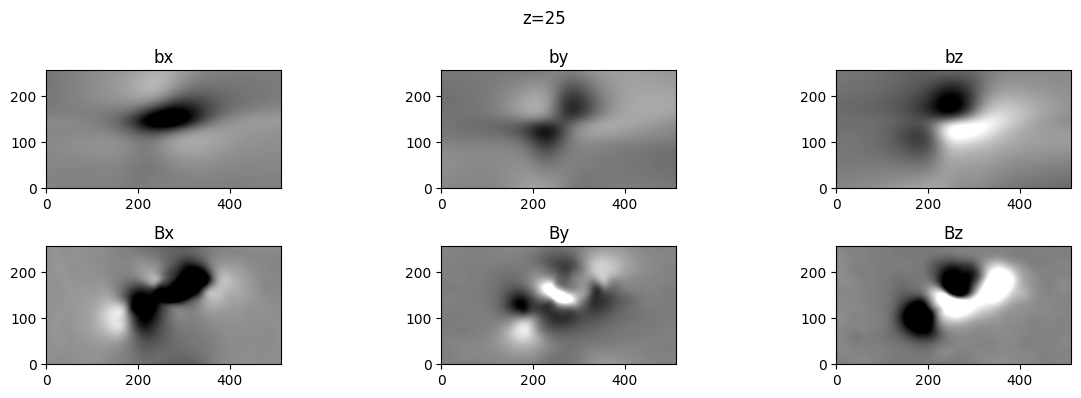

In [10]:
plot_overview(b, b_true, z=25, b_norm=100)

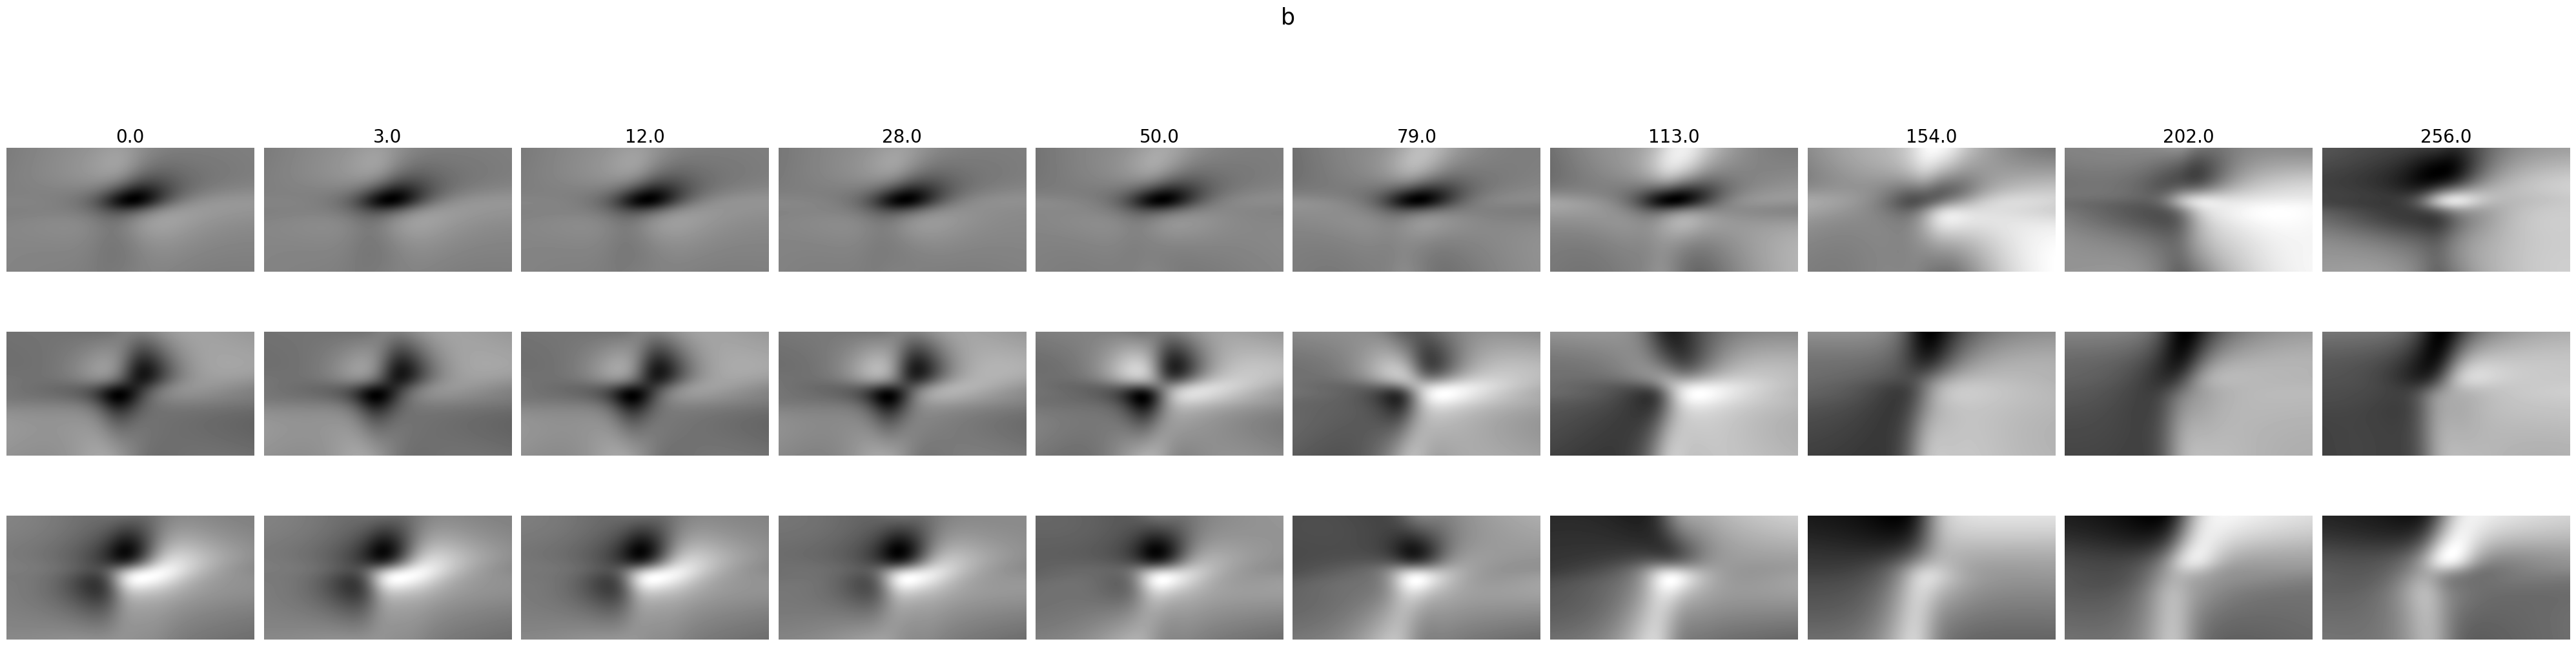

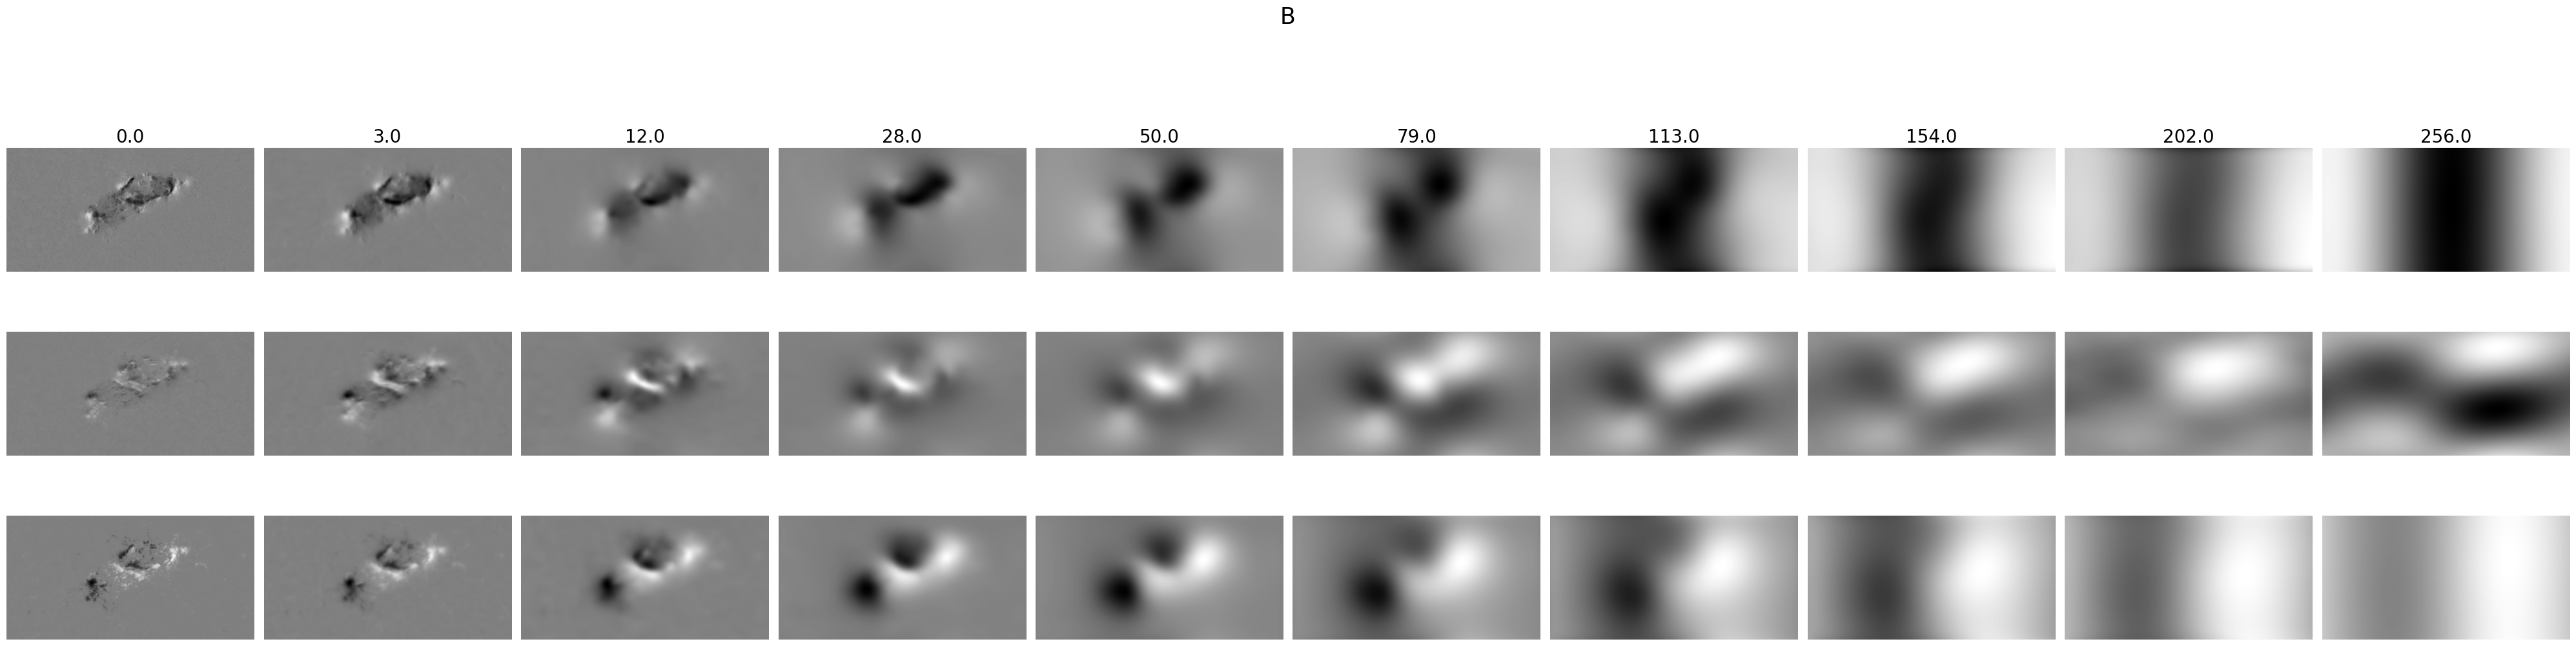

In [11]:
plot_sample(b, b_true)

Both the divergence and the angle between the currents and magnetic field should be small.
(ideally mean divergence `<0.1` and sigma `<10` degree; the exact values depend on the selected active region and lambda weights)

sig_J * 1e2: 34.8158; Lf: 0.1245; Ld: 0.0782
DIVERGENCE [1/pix]: 0.0043; THETA [deg] 20.3747
DIVERGENCE [1/pix]: 0.0043; THETA [deg] 20.3747


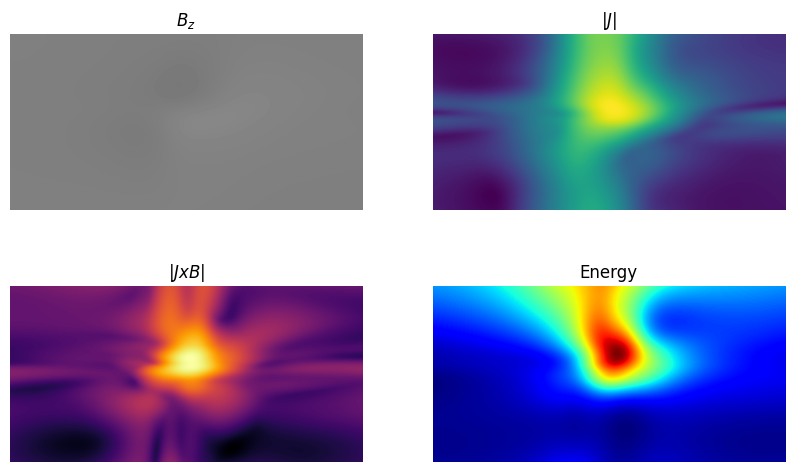

In [12]:
valid(b)

/userhome/jeon_mg/workspace/2023_007_zpinn/example/notebooks/utils/metric.py:50: RuntimeWarning: invalid value encountered in divide
  sigma = vector_norm(lorentz_force(b, j)) / vector_norm(b) / vector_norm(j)


Both the divergence and the angle between the currents and magnetic field should be small.
(ideally mean divergence `<0.1` and sigma `<10` degree; the exact values depend on the selected active region and lambda weights)

sig_J * 1e2: 72.0747; Lf: 57.5472; Ld: 10.7184
DIVERGENCE [1/pix]: 129488.1276; THETA [deg] nan
DIVERGENCE [1/pix]: 0.0033; THETA [deg] 46.1162


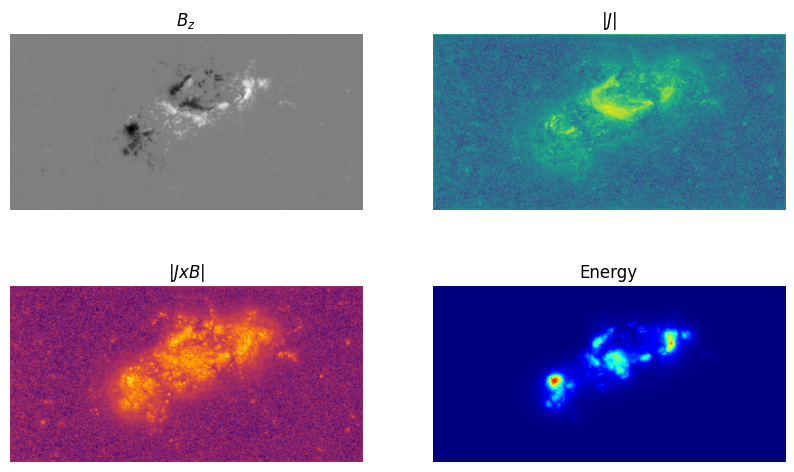

In [13]:
valid(b_true)